In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/song-popularity/dataset.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [3]:
data = pd.read_csv('/kaggle/input/song-popularity/dataset.csv')
data = data.dropna()
print(data.head())
print(data.info())

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


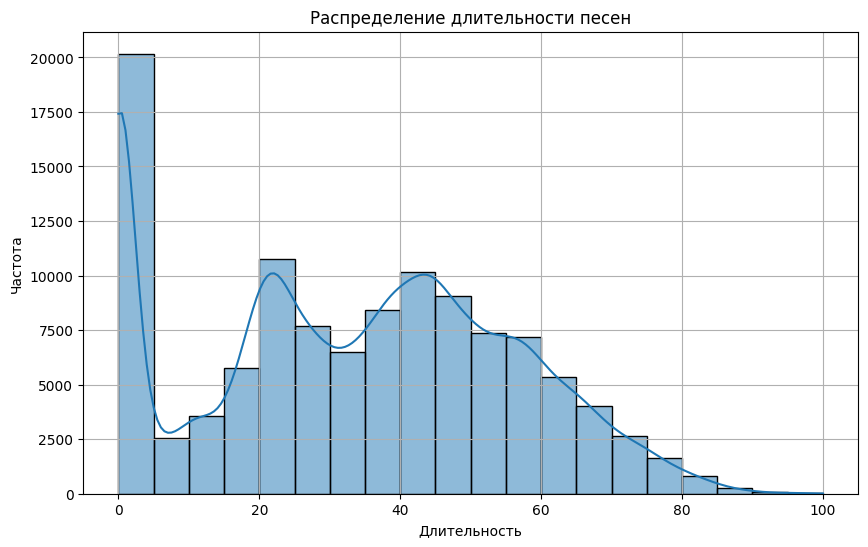

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data['popularity'], bins=20, kde=True)
plt.title('Распределение длительности песен')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.grid()
plt.show()

График показывает распределение популярности песен. Мы видим, что большинство песен имеют популярность ниже 50. Это может указывать на то, что высокопопулярные песни значительно реже встречаются в наборе данных. Этот график полезен для понимания общего уровня популярности песен в нашем наборе.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


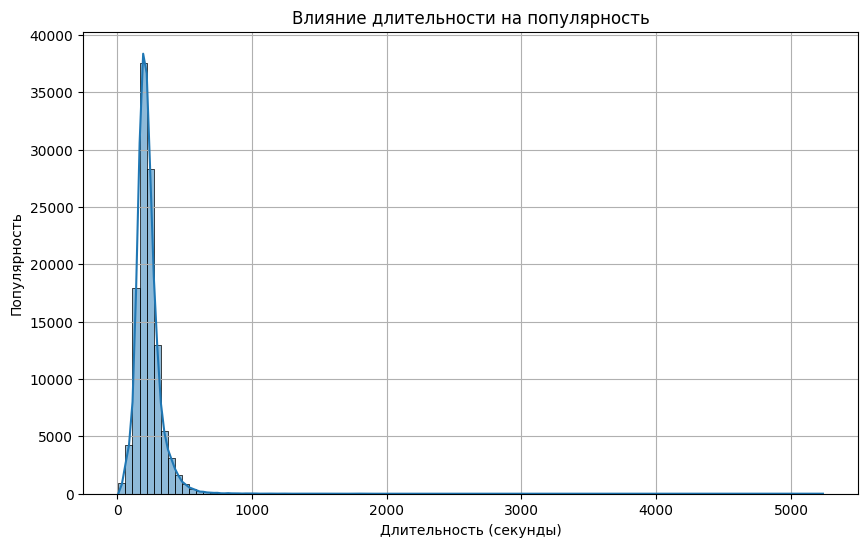

In [5]:
plt.figure(figsize=(10, 6))
data['duration_s'] = data['duration_ms'] / 1000
sns.histplot(data['duration_s'], bins=100, kde=True)
plt.title('Влияние длительности на популярность')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Популярность')
plt.grid()
plt.show()

На графике видно, что длительность песни не показывает четкой зависимости от ее популярности. Большинство песен имеют длительность около 3-4 минут (180 - 240 секунд), но это не гарантирует высокую популярность. Этот график не подтвердил мою гипотезу о том, что более длинные песни могут быть более популярными.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


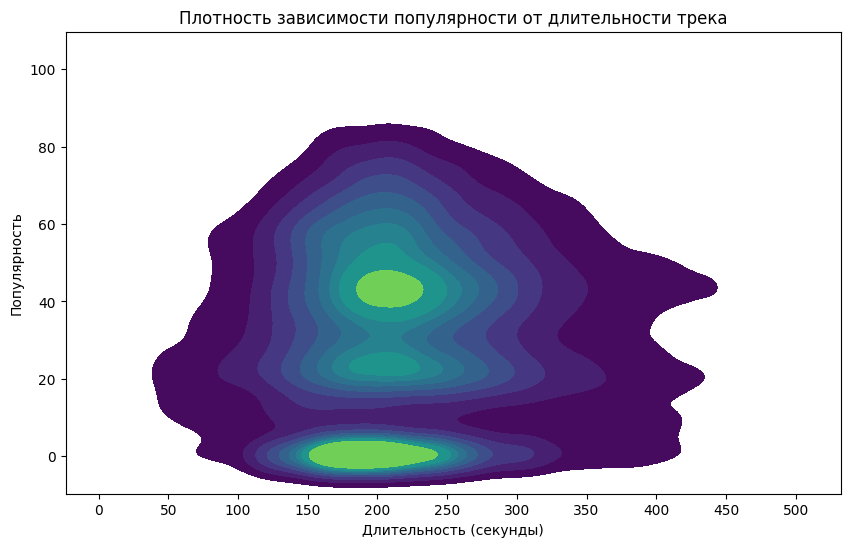

In [8]:
data_filtered = data[data['duration_s'] <= 500]
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_filtered, x="duration_s", y="popularity", cmap="viridis", fill=True)
max_duration = data_filtered['duration_s'].max()
plt.xticks(range(0, int(max_duration) + 50, 50))
plt.title("Плотность зависимости популярности от длительности трека")
plt.xlabel("Длительность (секунды)")
plt.ylabel("Популярность")
plt.show()

Из данного графика можно подчернуть, что в основном авторы делают песни длительностью 150-250 секунд, это время в свою очередь является максимально востребованным у треков

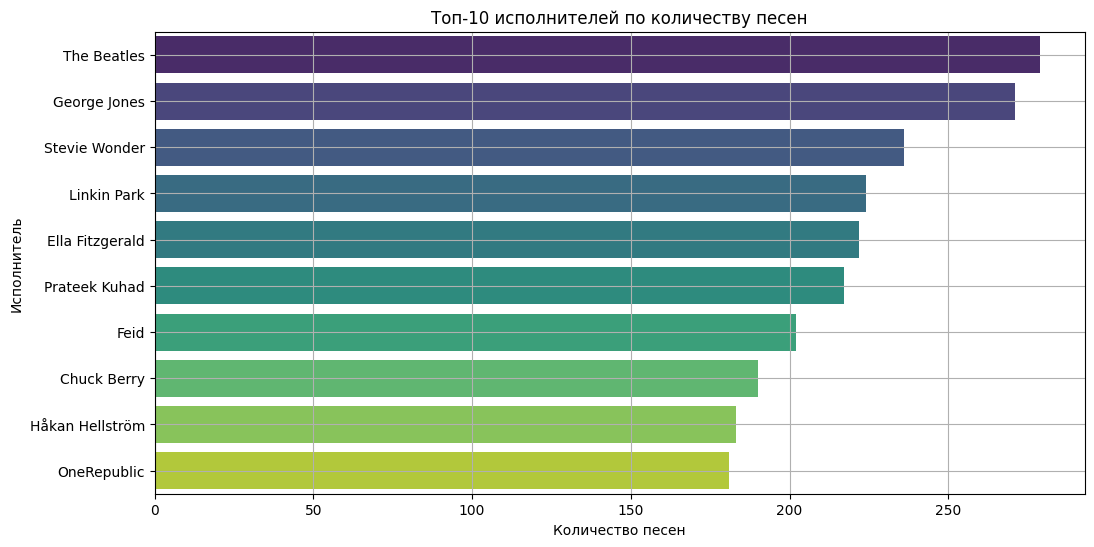

In [7]:
plt.figure(figsize=(12, 6))
top_artists = data['artists'].value_counts().nlargest(10)
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Топ-10 исполнителей по количеству песен')
plt.xlabel('Количество песен')
plt.ylabel('Исполнитель')
plt.grid()
plt.show()

График показывает, что некоторые исполнители имеют значительно больше песен в наборе данных, чем другие. Это может указывать на их активность или популярность в определённый период времени. Однако это не обязательно означает, что их песни более популярны; для этого потребуется дополнительный анализ.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


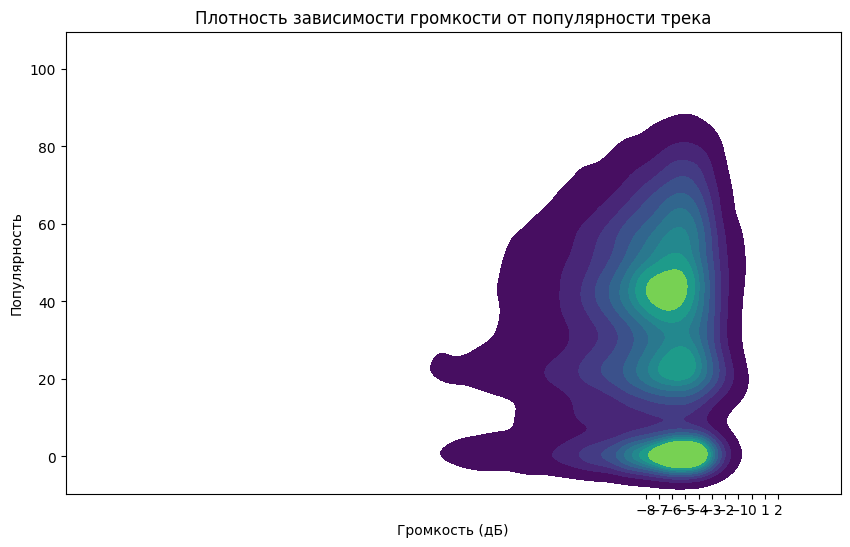

In [8]:

plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="loudness", y="popularity", cmap="viridis", fill=True)
plt.xticks(range(-8, 3))
plt.title("Плотность зависимости громкости от популярности трека")
plt.xlabel("Громкость (дБ)")
plt.ylabel("Популярность")
plt.show()

График показывает, что громкость не имеет четкой зависимости от популярности. Некоторые очень громкие песни могут быть менее популярны, в то время как более тихие треки могут иметь высокий уровень популярности. Это указывает на то, что другие факторы также играют важную роль в восприятии музыки.

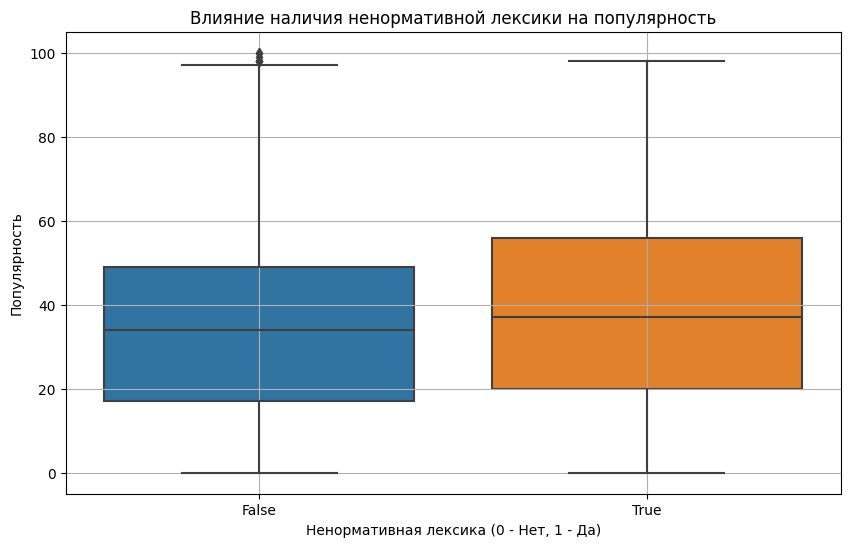

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='explicit', y='popularity', data=data)
plt.title('Влияние наличия ненормативной лексики на популярность')
plt.xlabel('Ненормативная лексика (0 - Нет, 1 - Да)')
plt.ylabel('Популярность')
plt.grid()
plt.show()

Этот график демонстрирует, что наличие ненормативной лексики положительно влиет на популярность треков, но перевес не настолько большой чтобы считать это сильно влияющим фактором на успех

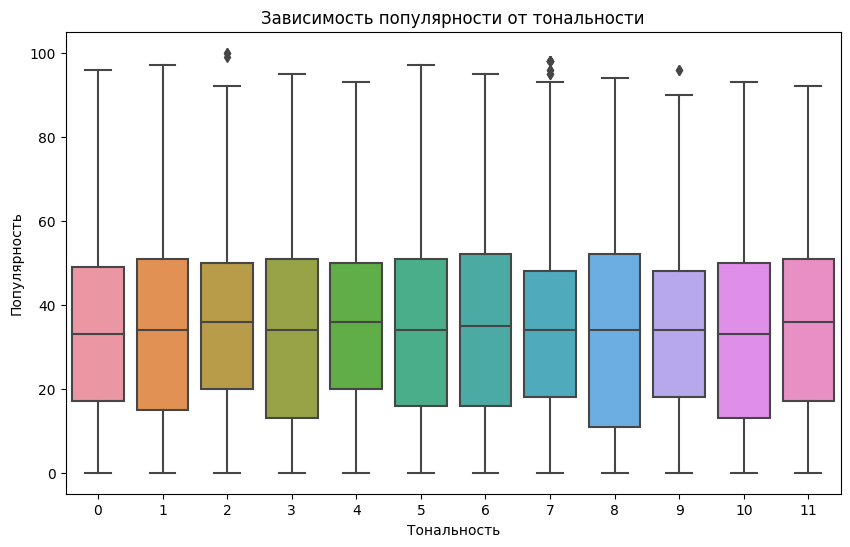

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x="key", y="popularity")
plt.title("Зависимость популярности от тональности")
plt.xlabel("Тональность")
plt.ylabel("Популярность")
plt.show()

Из графика можем вынести, что тональность никак не влияет на тональность

**Feature Engineering**

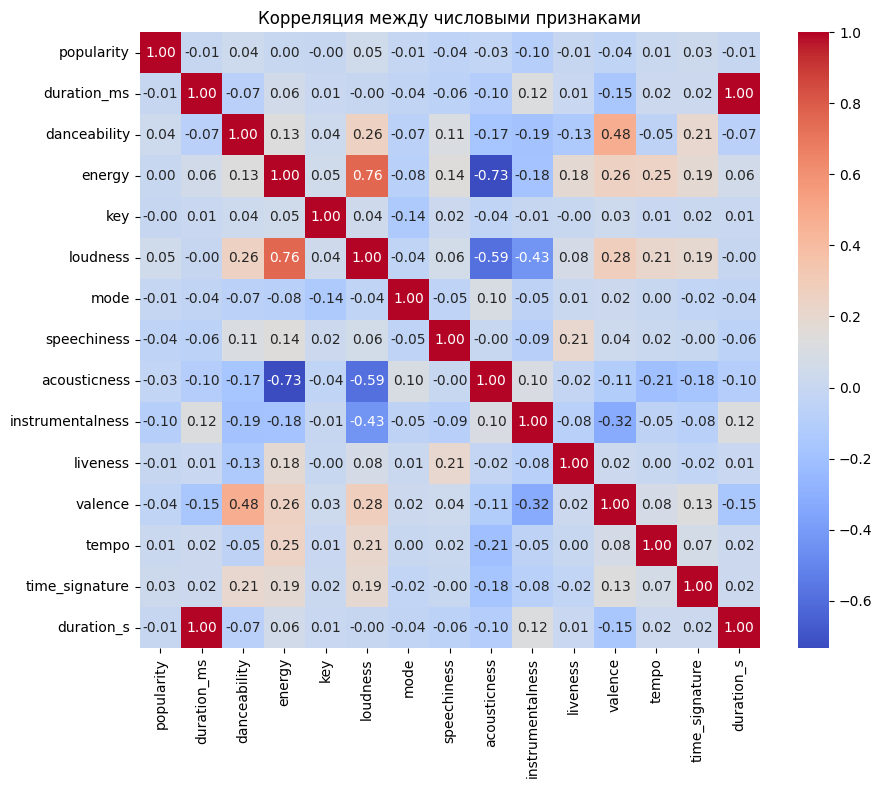

In [6]:
if ('Unnamed: 0' in data.columns): data.drop(columns=['Unnamed: 0'], inplace = True)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляция между числовыми признаками')
plt.show()

В данной таблице мы видим, что самые маловлиятельные параметры это "key", "mode".
Так же самые влиятельные друг на друга параметры это "energy" и "loudness", "energy" и "acousticness", "daceability" и "valence"

In [7]:
#удаляем самые маловлиятельные параметры
del data['key']
del data['mode']


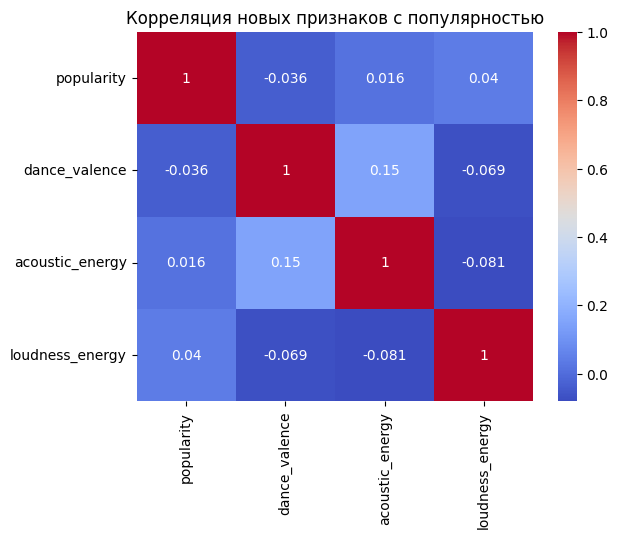

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Загрузка данных

# Создание категориальных признаков на основе продолжительности
# short 0-120  standart 120-240  long 240-1000
data['duration_category'] = pd.cut(data['duration_s'], bins=[0, 120, 240, 1000], labels=['short', 'standart', 'long'])
# Создание категориальных признаков на основе темпа
data['tempo_category'] = pd.cut(data['tempo'], bins=[0, 100, 120, 140, float('inf')], labels=['slow', 'medium', 'fast', 'very fast'])

# Создание бинарных признаков
data['is_explicit'] = data['explicit'].astype(int)  # Преобразование булевого значения в целое число

# Создание взаимодействий между признаками
data['dance_valence'] = data['danceability'] * data['valence']
data['acoustic_energy'] = data['acousticness'] * data['energy'] 
data['loudness_energy'] = data['loudness'] * data['energy'] 

# Нормализация и стандартизация

scaler = StandardScaler()
data[['danceability', 'energy', 'loudness', 'tempo']] = scaler.fit_transform(data[['danceability', 'energy', 'loudness', 'tempo']])
# приводим громкость к диапазону от 0 до 1
data['loudness_normalized'] = (data['loudness'] - data['loudness'].min()) / (data['loudness'].max() - data['loudness'].min()) 

# Удаление ненужных признаков
if ('track_id' in data.columns) :
    data.drop(columns=['track_id', 'artists', 'album_name', 'track_name'], inplace=True)

# Корреляция новых признаков с популярностью
correlation_matrix = data[['popularity', 'dance_valence', 'acoustic_energy', 'loudness_energy']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция новых признаков с популярностью')
plt.show()

In [10]:
#Исправление типов
numerical_features = data.select_dtypes(include=['number', 'float64', 'int64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()

from sklearn.preprocessing import LabelEncoder
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

**Обучение моделей**

In [11]:
#Добавление всех необходимых библиотек
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict
import keras

#Подготовка данных для подели

X = data.drop(columns=['popularity'])
y = data['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
#Создание функции для вычисление метрик
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }
    return metrics

In [13]:
# Линейная регрессия
model_lr = LinearRegression()

# Кросс-валидация
y_pred = cross_val_predict(model_lr, X_train, y_train, cv=5)

# Оценка
metrics_linear = evaluate_model(y_train, y_pred)
print('Линейная модель:', metrics_linear)

Линейная модель: {'MAE': 18.151689513878704, 'MSE': 479.43027916064807, 'RMSE': 21.895896400025464, 'R2': 0.0369855545897837}


Анализ метрик:
MAE: Указывает на среднее отклонение предсказанной популярности от фактической на 18.15 единиц, что говорит о недостаточной точности модели.
MSE: Высокое значение 479.43 подтверждает значительные ошибки в предсказаниях.
RMSE: Значение 21.90 также указывает на заметные отклонения между предсказанными и реальными значениями.
R²: Низкий коэффициент 0.037 показывает, что модель объясняет лишь 3.7% вариации в данных, что свидетельствует о слабой предсказательной способности.

In [17]:
# Дерево решений
model_dt = DecisionTreeRegressor(random_state=42)
# Кросс-валидация
y_pred = cross_val_predict(model_dt, X_train, y_train, cv=5)

# Оценка
metrics_tree = evaluate_model(y_train, y_pred)
print('Дерево решений:', metrics_tree)

Дерево решений: {'MAE': 14.362362076193184, 'MSE': 514.5230853513424, 'RMSE': 22.68310131686896, 'R2': -0.03350410941472037}


Анализ метрик:
MAE: Среднее отклонение предсказанной популярности от фактической составляет 14.36 единиц, что указывает на приемлемую точность модели.
MSE: Значение 514.52 подтверждает наличие ошибок в предсказаниях, но оно выше, чем у линейной модели.
RMSE: Значение 22.68 также указывает на заметные отклонения между предсказанными и реальными значениями.
R²: Низкий коэффициент -0.0335 говорит о том, что модель не объясняет вариацию в данных и даже хуже, чем простое среднее значение.

In [21]:
# Градиентный бустинг
model_gb = GradientBoostingRegressor(random_state=42)

# Кросс-валидация
y_pred = cross_val_predict(model_gb, X_train, y_train, cv=5)

# Оценка
metrics_boosting = evaluate_model(y_train, y_pred)
print('Градиентный бустинг:', metrics_boosting)

Градиентный бустинг: {'MAE': 16.251993768676584, 'MSE': 401.9986762097834, 'RMSE': 20.04990464340874, 'R2': 0.1925196445590256}


Анализ метрик:
MAE: Среднее отклонение предсказанной популярности от фактической составляет 16.25 единиц, что указывает на приемлемую точность модели.
MSE: Значение 402.00 подтверждает наличие ошибок в предсказаниях, но оно ниже, чем у дерева решений.
RMSE: Значение 20.05 также указывает на заметные отклонения между предсказанными и реальными значениями.
R²: Коэффициент 0.1925 показывает, что модель объясняет около 19.25% вариации в данных, что является улучшением по сравнению с предыдущими моделями.

In [18]:
# Нейронная сеть
model_nn = MLPRegressor(random_state=42)
# Кросс-валидация
y_pred = cross_val_predict(model_nn, X_train, y_train, cv=5)

# Оценка
neiro_mertic = evaluate_model(y_train, y_pred)
print('Нейронная сеть:', neiro_mertic)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Нейронная сеть: {'MAE': 16.798955683399203, 'MSE': 434.4680917447054, 'RMSE': 20.84389818975101, 'R2': 0.12729949148713482}


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Анализ метрик:
MAE: Среднее отклонение предсказанной популярности от фактической составляет 16.80 единиц, что указывает на приемлемую, но не идеальную точность модели.
MSE: Значение 434.47 подтверждает наличие ошибок в предсказаниях, хотя оно ниже, чем у градиентного бустинга.
RMSE: Значение 20.84 также указывает на заметные отклонения между предсказанными и реальными значениями.
R²: Коэффициент 0.1273 показывает, что модель объясняет около 12.73% вариации в данных, что является улучшением по сравнению с линейной регрессией и деревом решений, но все еще достаточно низким.

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 619.6736 - val_loss: 470.6040
Epoch 2/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 461.4115 - val_loss: 461.9530
Epoch 3/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 457.7158 - val_loss: 457.4597
Epoch 4/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 451.0049 - val_loss: 456.2924
Epoch 5/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 447.1914 - val_loss: 457.6978
Epoch 6/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 446.4969 - val_loss: 452.8359
Epoch 7/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 441.1923 - val_loss: 449.4110
Epoch 8/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 439.8642 - val_loss: 450.8911
Epoch 9/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 438.8498 - val_loss: 447.0075
Epoch 10/10
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 437.0312 - val_loss: 445.8093
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step  
Нейронная сеть: {'MAE': 16.828956597469872, '

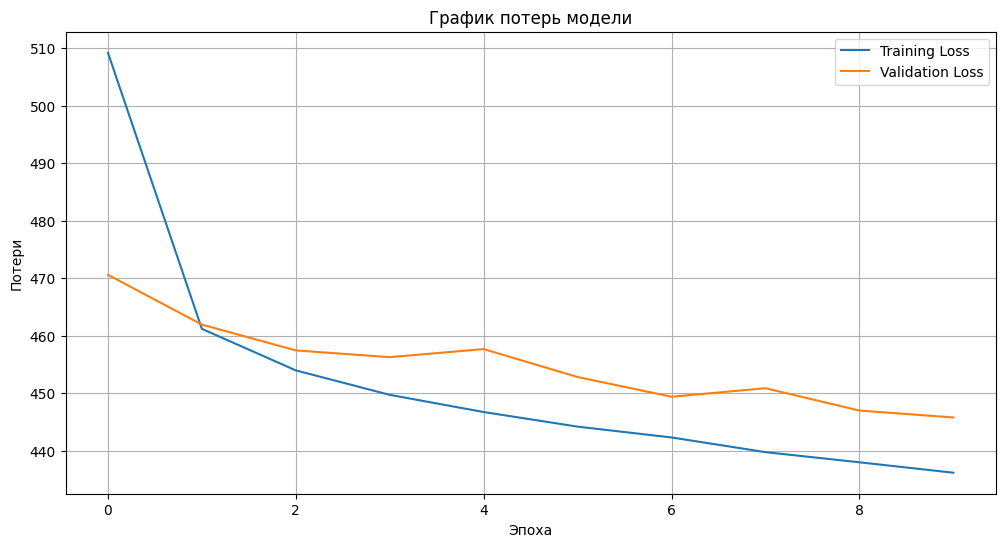

In [19]:
# Построение модели
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Тренировка модели и сохранение истории
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred = model.predict(X_train).flatten()

metrics_nn = evaluate_model(y_train, y_pred)
print('Нейронная сеть:', metrics_nn)

# Построение графика потерь
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График потерь модели')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid()
plt.show()

Анализ метрик:
MAE: Среднее отклонение предсказанной популярности от фактической составляет 16.83 единиц, что указывает на приемлемую, но не идеальную точность модели.
MSE: Значение 434.57 подтверждает наличие ошибок в предсказаниях, хотя оно ниже, чем у некоторых других моделей.
RMSE: Значение 20.85 также указывает на заметные отклонения между предсказанными и реальными значениями.
R²: Коэффициент 0.1271 показывает, что модель объясняет около 12.71% вариации в данных, что является улучшением по сравнению с линейной регрессией и деревом решений, но все еще достаточно низким.

2850/2850 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 441.2164
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

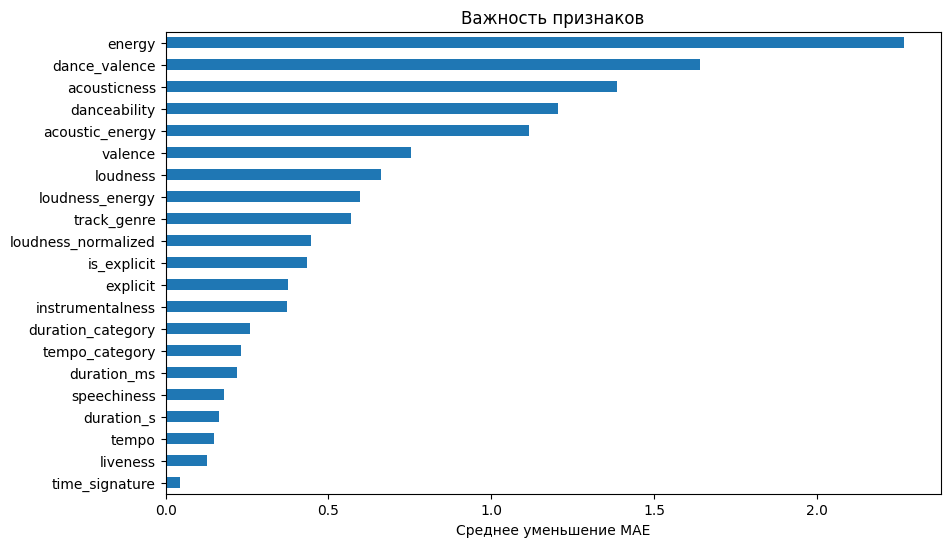

In [22]:
# Важность признаков с помощью permutation importance
model.fit(X_train, y_train)
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

importances = pd.Series(result.importances_mean, index=X.columns)



# Визуализация важности признаков

importances.sort_values().plot(kind='barh', figsize=(10,6))

plt.title('Важность признаков')

plt.xlabel('Среднее уменьшение MAE')

plt.show()

Ключевые признаки

Энергничность (energy):

Этот признак оказывает наибольшее влияние на предсказания модели, что говорит о том, что популярность песни во многом зависит от её энергичности. Совокупность танцевальности и позитивность, а также акустичность эти признаки также играют важную роль. 

Второстепенные признаки

Такие признаки как танцевальность, жанр трека и громкость, тоже влияют на популярность, но не являются главными.

Маловлияющие признаки

Такие характеристики как, живое исполнение, time_signature и темп влияют на популярность меньше всего.телем.


Заключение


Анализ показывает, что популярность трека зависит как от жанровых и громкостных характеристик, так и от эмоциональных и вокальных аспектов. Эти выводы могут быть полезны для

:
Оптимизации треков перед их релизом.
Формирования рекомендаций для исполнителей и продюсеров.
Разработки систем рекомендаций на основе предпочтений пользовате

лей.
Тем не менее, несмотря на все эти факторы, предсказать популярность трека с абсолютной точностью невозможно. Популярность является метрикой, которая зависит от множества факторов, многие из которых трудно учесть для каждого конкретного трека.
